# Import

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import time

# pour traitement du language (NLP)
import string
import nltk
nltk.download('wordnet')
from nltk import tokenize, pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.stem import PorterStemmer, WordNetLemmatizer
from wordcloud import WordCloud
from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from gensim.corpora import Dictionary
from sklearn.manifold import TSNE

import mlflow
import pickle

from sklearn import metrics as metrics_sklearn

[nltk_data] Downloading package wordnet to /home/slerendu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
mlflow.autolog()
from mlflow import log_metric, log_param, log_params, log_artifacts

2023/08/12 10:03:32 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.


In [4]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [5]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [6]:
mlflow.set_tracking_uri("http://localhost:5000")

# Méthodes

### Méthodes pour les datas

In [7]:
# pour les pie charts, pour afficher les pourcentages et les libellés uniquement avec le taux > limit_perc%
limit_perc = 5
def show_perc(pct):
    """ Affiche le pourcentage de chaque portion si la condition est vérifiée """
    return ('%.1f%%' % pct) if pct > limit_perc else ''

def show_labels(data):
    list = []
    for val, cnt in data.items():
        if (cnt*100/np.sum(data)) > limit_perc :
            list.append(val)
        else:
            list.append('')
    return list

In [8]:
def show_unique_values(df, col, display_pie=True, silent=False):
    """
    Affiche la liste des valeurs uniques contenues dans une colonne
    Affiche le pie chart de ces données également
    """
    temp_val_count = df[col].value_counts(normalize=True)
    df_val_count = temp_val_count.rename_axis("label").to_frame("%")
    df_val_count["%"] = round(df_val_count["%"]*100, 2)
    df_val_count["%_cumul"] = df_val_count["%"].cumsum()
    # afficher la majeur partie des catégories
    sub_display = df_val_count.loc[df_val_count["%_cumul"] <= 85, :]
    
    if silent:
        return sub_display
    
    if len(sub_display) < 5:
        display(df_val_count.head())
    else:
        display(sub_display.head(len(sub_display)))
    if display_pie:
        temp_val_count.plot(kind='pie', autopct=show_perc, labels=show_labels(temp_val_count), label='')
        plt.axis('equal')
        plt.show()
    return sub_display

### Méthodes pour preprocessing

In [9]:
def get_wordnet_pos(word):
    """Return the corresponding character for a word use in the lemmatization
    
    Parameters:
    word (str): a word
    
    Returns:
    str: the corresponding character
    """
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [10]:
def detailled_lemmatizer(sentence):
    """Lemmatize a sentence and return it
    
    Parameters:
    sentence (list(str)): a list of words
    
    Returns:
    (list(str)): a list of lemmatized words
    """
    lemmatizer = WordNetLemmatizer()
    result = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in sentence]
    return result

In [11]:
def clean_text(X):
    X = X.split()
    X_wo_arobas = [x for x in X if not x.startswith("@")]
    X_new = [x for x in X_wo_arobas if not x.startswith("http")]
    return ' '.join(X_new)

In [12]:
def filter_pos_tag(df, col, tags_to_remove=[], debug=False):
    """Filter words from a list of Part-Of-Speech tags
    
    Parameters:
    df (dataframe): input dataframe
    col (str): column to process
    tags_to_remove list(str): a list of POS tag
    debug (bool): show debug elements
    
    Returns:
    list(list(str)): return a list of document. Each document is a list of words    
    """
    result = []
    if not tags_to_remove:
        print("Aucun filtre n'a été défini.")
        return df[col]
    for index, row in df.iterrows():
        temp_res = pos_tag(row[col])
        temp_res = [x for x in temp_res if x[1] not in tags_to_remove]
        # if debug:
        #     print(temp_res[0])
        result.append([x[0] for x in temp_res])
    return result

In [13]:
def filter_exclude_words(df, col, words_to_exclude=[], debug=False):
    """Filter words from a list of specific words
    
    Parameters:
    df (dataframe): input dataframe
    col (str): column to process
    words_to_exclude list(str): a list of words
    debug (bool): show debug elements
    
    Returns:
    list(list(str)): return a list of document. Each document is a list of words    
    """
    result = []
    if not words_to_exclude:
        print("Aucun mots à exclure.")
        return df[col]
    for index, row in df.iterrows():
        result.append([x for x in row[col] if x not in words_to_exclude])
    return result

In [14]:
def display_wordcloud(corpus, debug=False):
    """Display a WordCloud picture from a corpus
    
    Parameters:
    corpus (dict): a Counter dictionary with the frequency of each words
    debug (bool): show debug elements
    
    Returns:
    
    """
    wordcloud = WordCloud(
            random_state = 42,
            normalize_plurals = False,
            width = 600, 
            height= 300,
            max_words = 100,
            stopwords = [],
            colormap="BrBG")

    wordcloud.generate_from_frequencies(corpus)
    
    fig, ax = plt.subplots(1,1, figsize = (12,8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")

In [15]:
def clean_textism(sentence):
    neo_sentence = []
    for word in sentence:
        if word == 'u':
            neo_sentence.append('you')
        elif word == 'r':
            neo_sentence.append('are')
        elif word == 'ur':
            neo_sentence.append('your')
        elif word == 'some1':
            neo_sentence.append('someone')
        elif word == 'yrs':
            neo_sentence.append('years')
        elif word == 'hrs':
            neo_sentence.append('hours')
        elif word == 'mins':
            neo_sentence.append('minutes')
        elif word == 'secs':
            neo_sentence.append('seconds')
        elif word == 'pls' or word == 'plz':
            neo_sentence.append('please')
        elif word == '2morow':
            neo_sentence.append('tomorrow')
        elif word == '2day':
            neo_sentence.append('today')
        elif word == '2nite':
            neo_sentence.append('tonight')
        elif word == '4got' or word == '4gotten':
            neo_sentence.append('forget')
        elif word == 'amp' or word == 'quot' or word == 'lt' or word == 'gt' or word == '½25':
            neo_sentence.append('')
        else:
            neo_sentence.append(word)
    return neo_sentence

In [16]:
def preprocessing_words(df, col, stem_or_lemma="stem", debug=False):
    """Compute all the basics string tranformations in NLP
    Normalisation, Tokenization, Remove of stopwords, Stemmation or Lemmatization
    
    Parameters:
    df (dataframe): input dataframe
    col (str): column to process
    stem_or_lemma (str): choose between stemmation or lemmatization
    debug (bool): show debug elements
    
    Returns:
    list(list(str)): return a list of document. Each document is a list of words
    """
    result = []    
    # building stopwords list
    stopW = stopwords.words('english')
    stopW.extend(string.punctuation)
    
    for index, row in df.iterrows():        
        temp_res = ""
        # normalisation
        temp_res = row[col].lower()
        # tokenization
        tk = tokenize.TweetTokenizer(reduce_len=True)
        temp_res = tk.tokenize(temp_res)
        
        # clean the sms language to usefull langage
        temp_res = clean_textism(temp_res)
        
        # remove stopwords
        temp_res = [word for word in temp_res if word not in stopW]
        
        # stemmation or lemmatization
        if stem_or_lemma == "stem":
            stemmer = PorterStemmer()
            temp_res = [stemmer.stem(elt) for elt in temp_res]
        elif stem_or_lemma == "lemma":
            temp_res = detailled_lemmatizer(temp_res)
        else:
            print("stem or lemma only")
            
        result.append(temp_res)
    return result

In [17]:
def natural_language_processing(
    df, col, stem_or_lemma="stem", tags_to_remove=[], words_to_exclude=[],
    max_threshold=999, min_threshold=0, word_cloud=True, debug=False):
    """Compute NLP preprocessing methods
    
    Parameters:
    df (dataframe): input dataframe
    col (str): column to process
    stem_or_lemma (str): choose between stemmation or lemmatization
    tags_to_remove list(str): a list of POS tag
    words_to_exclude list(str): a list of words
    max_threshold (int): upper threshold to filter word frequency
    min_threshold (int): lower threshold to filter word frequency
    word_cloud (bool): display WordCloud representation
    debug (bool): show debug elements
    
    Returns:
    list(list(str)): return a list of document. Each document is a list of words    
    """
    # df = input_df.copy()
    # supprimer des mots spécifiques à twitter (commençant par @ et hhtp)
    df[col] = df[col].apply(clean_text)
    
    # preprocessing part
    preproc_res = preprocessing_words(df, col, stem_or_lemma=stem_or_lemma, debug=debug)
    df.insert(0, 'preproc_text', preproc_res)
    
    # filter by pos tag part
    filtpos_res = filter_pos_tag(df, "preproc_text", tags_to_remove=tags_to_remove, debug=debug)
    df.insert(0, 'filtpos_text', filtpos_res)
    
    # filter by excluding words
    filtexcl_words = filter_exclude_words(df, "filtpos_text", words_to_exclude=words_to_exclude, debug=debug)
    df.insert(0, 'filtexcl_words', filtexcl_words)
    
    if debug:
        display(df[[col, 'preproc_text', 'filtpos_text', 'filtexcl_words']].head())
    
    # concatenate all documents into a single corpus
    corpus = df["filtexcl_words"].tolist()
    corpus = [item for sublist in corpus for item in sublist]
    
    word_counts = Counter(corpus)
    print("Il y a un total de", len(word_counts), "mots différents dans tout le corpus.")
    word_counts_threshold = {x: count for x, count in word_counts.items() if count > min_threshold}
    word_counts_threshold = {x: count for x, count in word_counts_threshold.items() if count < max_threshold}
    print("Après filtrage, on garde les mots aparaissant plus de", min_threshold,
          "fois et moins de", max_threshold, "fois. Il reste alors",
          len(word_counts_threshold), "mots différents dans tout le corpus.\n")
    word_counts = Counter(word_counts_threshold)
    
    if debug:
        print("------------ Top 20 plus communs : ------------")
        display_most_common = [(i, word_counts[i], word_counts[i] / len(corpus) * 100.0) for i, count in word_counts.most_common(20)]
        for elt in display_most_common:
            print(elt)
        print("\n------------ Top 20 moins communs : ------------")
        display_least_common = [(i, word_counts[i], word_counts[i] / len(corpus) * 100.0) for i, count in word_counts.most_common()[-20:]]
        for elt in display_least_common:
            print(elt)
        
    simplified_corpus = word_counts_threshold.keys()
    
    # display wordcloud part
    if word_cloud:
        display_wordcloud(word_counts_threshold, debug=debug)
    
    return simplified_corpus

### Méthodes pour BOW and Word Embedding

In [18]:
def representation_by_tf_idf(corpus):
    """Compute corpus into a tf-idf vectorisation
    
    Parameters:
    corpus (list(list(str)): a list of documents
    
    Returns:
    a matrix of TF-IDF features
    the list of features names
    """
    vect = TfidfVectorizer(ngram_range=(1, 1))
    tfidf_mat = vect.fit_transform(corpus)
    features_names = vect.get_feature_names_out()
    return tfidf_mat, features_names

In [19]:
from gensim.models.doc2vec import TaggedDocument, Doc2Vec
def representation_by_doc2vec(corpus):
    X = [TaggedDocument(doc, [i]) for i, doc in enumerate(corpus)]

    # Train doc2vec model
    doc2vec = Doc2Vec()
    doc2vec.build_vocab(X)
    doc2vec.train(X, total_examples=doc2vec.corpus_count, epochs=doc2vec.epochs)

    # Vectorize text
    X = [doc2vec.infer_vector(doc.words) for doc in X]
    return X

### Méthodes pour les métriques

In [20]:
def display_confusion_matrix(actual_class, predict_class, display_labels=None, specifity=False, display_mat=True):
    """display the confusion matrix
    
    Parameters:
    actual_class : serie of the actual classes
    predict_class : serie of the predicted classes
    display_labels list(str)) : list of labels to show in the confusion matrix
    
    Returns:
    
    """
    print("Calcul et affichage de la matrice de confusion")
    # pour calculer la matrice de confusion
    cm = metrics_sklearn.confusion_matrix(actual_class, predict_class)#, labels=display_labels)
    cm = cm.T
    
    # pour afficher la matrice de confusion
    if display_mat:
        displ = metrics_sklearn.ConfusionMatrixDisplay(cm, display_labels=display_labels)
        displ.plot()
        displ.ax_.xaxis.tick_top()
        displ.ax_.xaxis.set_label_position('top') 
        plt.xlabel('Actual Label')
        plt.ylabel('Predicted Label')
        plt.gcf().axes[0].tick_params()
        plt.gcf().axes[1].tick_params()
        plt.show()
    
    # compute specificity
    if specifity:
        speci = cm[0, 0]/(cm[0, 0] + cm[1, 0])
        print("Spécificité :", speci)
        return speci
    
    return False

In [21]:
def plot_roc_curve(model_name, y_val, y_val_pred):  
    print("Calcul et affichage de la courbe ROC")
    [fpr_te, tpr_te, thr_te] = metrics_sklearn.roc_curve(y_val, y_val_pred)#, pos_label=1)
    plt.plot(fpr_te, tpr_te, color='coral', lw=2, label="")
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('1 - Specificity', fontsize=14)
    plt.ylabel('Sensitivity', fontsize=14)
    plt.title("ROC du classifier {}".format(model_name))

In [22]:
def display_classification_metrics(estimator, y_val, y_val_pred, list_metrics=["accuracy"], all_metrics=False, roc_curve=False, beta=1):
    print("Calcul et affichage des différentes métriques")
    result = {}
    if all_metrics:
        list_metrics = ["accuracy", "recall", "precision", "auc", "f1", "fbeta"]
    for met in list_metrics:
        if met == "accuracy":
            te_res = metrics_sklearn.accuracy_score(y_val, y_val_pred).round(3)
            print("Accuracy :", te_res)
        elif met == "precision":     
            te_res = metrics_sklearn.precision_score(y_val, y_val_pred, average='macro').round(3)
            print("Précision :", te_res)
        elif met == "recall":  
            te_res = metrics_sklearn.recall_score(y_val, y_val_pred, average='macro').round(3)
            print("Recall :", te_res)
        elif met == "auc":    
            te_res = metrics_sklearn.roc_auc_score(y_val, y_val_pred, average='macro').round(3)
            print("AUC :", te_res)
            if roc_curve:
                plot_roc_curve(type(estimator).__name__, y_val, y_val_pred)
        elif met == "f1":   
            te_res = metrics_sklearn.f1_score(y_val, y_val_pred, average='macro').round(3)
            print("F1-score :", te_res)
        elif met == "fbeta":
            te_res = metrics_sklearn.fbeta_score(y_val, y_val_pred, beta=beta, average='macro').round(3)
            print("Fbeta-score (beta=", beta,  ") :", te_res)
        else:
            print("La métrique", met, "n'est pas dans la liste suivante accuracy, recall, precision, auc, f1 et fbeta. Veuillez vérifier la saisie.")
        result[met] = te_res
    return result

In [23]:
from sklearn import metrics
def display_classification_report(y_true, y_pred, display_labels=None):
    print("Calcul et affichage du rapport de classification")
    clf_report = metrics.classification_report(y_true, y_pred, target_names=display_labels)
    print(clf_report)

### Méthodes pour les modèles de régression

In [24]:
from sklearn import naive_bayes
def get_naive_bayes_model(model_name="gaussian"):
    """return an instance of the model selected
    
    Parameters:
    model_name (str) : names of naive bayes model used
    
    Returns:
    instance of the model
    """
    if model_name == "gaussian":
        return naive_bayes.GaussianNB()
    elif model_name == "multinomial":
        return naive_bayes.MultinomialNB()
    elif model_name == "bernoulli":
        return naive_bayes.BernoulliNB()
    else:
        return -1

### Méthodes pour les Réseaux de neurones

In [25]:
from keras.preprocessing import text
def tokenize_corpus(corpus):
    tokenizer = text.Tokenizer()
    tokenizer.fit_on_texts(corpus)
    return tokenizer

2023/08/12 10:03:34 WARNING mlflow.tracking.fluent: Exception raised while enabling autologging for tensorflow: cannot import name '__version__' from partially initialized module 'keras' (most likely due to a circular import) (/home/slerendu/.local/lib/python3.10/site-packages/keras/__init__.py)


In [26]:
def word_embedding_by_word2vec(embed_dim, data):
    w2v_model = Word2Vec(data, vector_size=embed_dim, workers=8)
    # w2v_model.build_vocab(data)
    w2v_model.train(data, total_examples=len(data), epochs=50)
    return w2v_model

In [27]:
# !wget http://nlp.stanford.edu/data/glove.twitter.27B.zip
# !unzip data/glove.twitter.27B.zip
def word_embedding_by_glove(corpus):
    GLOVE_EMB = 'glove.twitter.27B.200d.txt'
      
    # compute embeddings index from GloVe
    embeddings_index = {}
    f = open(GLOVE_EMB)
    for line in f:
        values = line.split()
        word = value = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()
    print('Found %s word vectors.' %len(embeddings_index))
    return embeddings_index   

In [28]:
def compute_corpus_to_word_embedding(corpus, model_name="word2vec"):
    tokenizer = tokenize_corpus(corpus)
    word_index = tokenizer.word_index
    vocab_size = len(tokenizer.word_index) + 1  
    
    if model_name == "word2vec":
        embed_dim = 800
        
        # word embedding using Word2Vec
        w2v_model = word_embedding_by_word2vec(embed_dim, corpus)
        word_index = w2v_model.wv.key_to_index
        # vocab_size = len(word_index)
        
        # compute embedding matrix
        embedding_matrix = np.zeros((vocab_size, embed_dim))
        for word, i in tokenizer.word_index.items():
            if w2v_model.wv.__contains__(word):
                embedding_matrix[i] = w2v_model.wv.__getitem__(word)
    elif model_name == "glove":
        embed_dim = 200
        
        # word embedding using GloVe
        embeddings_index = word_embedding_by_glove(corpus)
        
        # compute embedding matrix
        embedding_matrix = np.zeros((vocab_size, embed_dim))
        for word, i in word_index.items():
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
                
    print("Embedding Matrix Shape:", embedding_matrix.shape)
    return embedding_matrix, tokenizer, embed_dim

In [29]:
import keras.backend as K
def specificity(y_true, y_pred):
    """
    param:
    y_pred - Predicted labels
    y_true - True labels 
    Returns:
    Specificity score
    """
    neg_y_true = 1 - y_true
    neg_y_pred = 1 - y_pred
    fp = K.sum(neg_y_true * y_pred)
    tn = K.sum(neg_y_true * neg_y_pred)
    specificity = tn / (tn + fp + K.epsilon())
    return specificity

In [30]:
def display_result_plot(history):
    spec,  val_spec  = history.history['specificity'], history.history['val_specificity']
    loss, val_loss = history.history['loss'], history.history['val_loss']
    epochs = range(len(spec))

    plt.plot(epochs, spec, 'b', label='Training spec')
    plt.plot(epochs, val_spec, 'r', label='Validation spec')
    plt.title('Training and validation specificity')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

In [31]:
def display_result_plot_auc(history):
    spec,  val_spec  = history.history['auc'], history.history['val_auc']
    loss, val_loss = history.history['loss'], history.history['val_loss']
    epochs = range(len(spec))

    plt.plot(epochs, spec, 'b', label='Training AUC')
    plt.plot(epochs, val_spec, 'r', label='Validation AUC')
    plt.title('Training and validation AUC')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

In [32]:
def create_neural_network_model(embedding_layer, init_scheme="ones"):
    # instance de neural network model
    model = keras.Sequential()
    
    # on ajoute toutes les couches nécessaires
    model.add(embedding_layer)
    model.add(layers.Conv1D(128, 5, activation='relu', kernel_initializer=init_scheme, bias_initializer='zeros'))
    model.add(layers.Flatten())
    model.add(layers.Dense(16, activation="relu", kernel_initializer=init_scheme, bias_initializer='zeros'))
    model.add(layers.Dense(16, activation="relu", kernel_initializer=init_scheme, bias_initializer='zeros'))
    model.add(layers.Dense(1, activation="sigmoid", kernel_initializer=init_scheme, bias_initializer='zeros'))
    
    # on crée les fonctions de loss et d'optimisation
    loss = losses.BinaryCrossentropy(from_logits=True)
    optimizer = optimizers.Adam(learning_rate=2e-4, epsilon=1e-08)
    
    # on compile le modèle
    model.compile(loss=loss, optimizer=optimizer, metrics=[specificity])
    model.summary()
    
    return model

In [33]:
def create_neural_network_model_auc(embedding_layer, init_scheme="ones"):
    # instance de neural network model
    model = keras.Sequential()
    
    # on ajoute toutes les couches nécessaires
    model.add(embedding_layer)
    model.add(layers.Conv1D(128, 5, activation='relu', kernel_initializer=init_scheme, bias_initializer='zeros'))
    model.add(layers.Flatten())
    model.add(layers.Dense(16, activation="relu", kernel_initializer=init_scheme, bias_initializer='zeros'))
    model.add(layers.Dense(16, activation="relu", kernel_initializer=init_scheme, bias_initializer='zeros'))
    model.add(layers.Dense(1, activation="sigmoid", kernel_initializer=init_scheme, bias_initializer='zeros'))
    
    # on crée les fonctions de loss et d'optimisation
    loss = losses.BinaryCrossentropy(from_logits=True)
    optimizer = optimizers.Adam(learning_rate=2e-4, epsilon=1e-08)
    
    # on compile le modèle
    model.compile(loss=loss, optimizer=optimizer, metrics=[keras.metrics.AUC()])
    model.summary()
    
    return model

In [34]:
def train_neural_network_model(model, X_train, y_train, X_val, y_val, epochs=20, batch_size=1024):
    # on crée les méthodes de callback permettant d'arrêter l'entraînement dès que certaines conditions sont remplies
    callbacks = [
        ReduceLROnPlateau(monitor='val_loss', patience=10, cooldown=0),
        EarlyStopping(monitor='val_specificity', min_delta=1e-4, patience=10)
    ]
 
    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs,
                        validation_data=(X_val, y_val), callbacks=callbacks,
                        verbose=1)
    
    return history

In [35]:
def train_neural_network_model_auc(model, X_train, y_train, X_val, y_val):
    # on crée les méthodes de callback permettant d'arrêter l'entraînement dès que certaines conditions sont remplies
    callbacks = [
        ReduceLROnPlateau(monitor='val_loss', patience=10, cooldown=0),
        EarlyStopping(monitor='val_auc', min_delta=1e-4, patience=10)
    ]
 
    history = model.fit(X_train, y_train, batch_size=1024, epochs=30,
                        validation_data=(X_val, y_val), callbacks=callbacks,
                        verbose=1)
    
    return history

# Preparing dataset

In [36]:
data = pd.read_csv("data/training.1600000.processed.noemoticon.csv", sep=',',
                   encoding="ISO-8859-1", names=["target", "id", "date", "flag", "user", "text"])

In [37]:
data.head()

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [38]:
data["target"].replace(4, 1, inplace=True)

,%,%_cumul
label,,
0,50.0,50.0
1,50.0,100.0


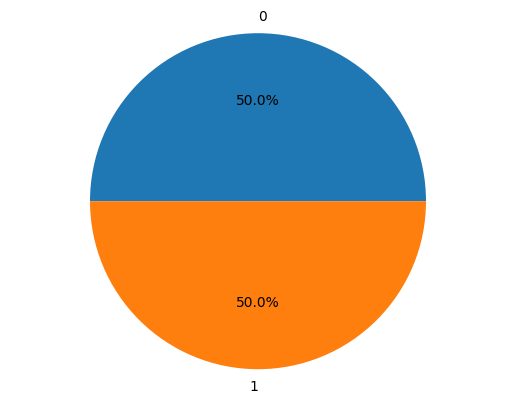

,%,%_cumul
label,,
0,50.0,50.0


In [39]:
show_unique_values(data, "target")

Sentiment du tweet 0 pour négatif et 4 pour positif  
Dans tous les cas, nous n'avons besoin que du texte du tweet et de la target

In [40]:
data.drop(columns=["id", "date", "flag", "user"], inplace=True)

In [41]:
print("The dataset is containing", data.shape[0], "lines and", data.shape[1], "columns.")

The dataset is containing 1600000 lines and 2 columns.


On commence par prendre un échantillon des données dans un premier temps : 10 000 de chaque target.

In [42]:
data_words = data.groupby(['target']).apply(pd.DataFrame.sample, n=10000, replace=True, random_state=42).reset_index(drop=True)

In [43]:
print("The sample dataset is containing", data_words.shape[0], "lines and", data_words.shape[1], "columns.")

The sample dataset is containing 20000 lines and 2 columns.


In [44]:
data_words.head()

,target,text
0,0,@ home studying for maths wooot ! im so going ...
1,0,Pickin up @misstinayao waitin on @sadittysash ...
2,0,@ProudGamerTweet I rather average 32370
3,0,"@ddlovato I'm trying to reach my dreams, but i..."
4,0,this song's middle change just doesn't want to...


In [45]:
negative_ex = data_words.query("target == 0")

In [46]:
negative_ex['text'].iloc[0]

'@ home studying for maths wooot ! im so going to fail this shit '

In [47]:
positive_ex = data_words.query("target == 1")

In [48]:
positive_ex['text'].iloc[2]

'@ashlili LIKE MEEEEEEEEE '

# Preprocessing

Il y a un total de 17694 mots différents dans tout le corpus.
Après filtrage, on garde les mots aparaissant plus de 0 fois et moins de 999 fois. Il reste alors 17687 mots différents dans tout le corpus.



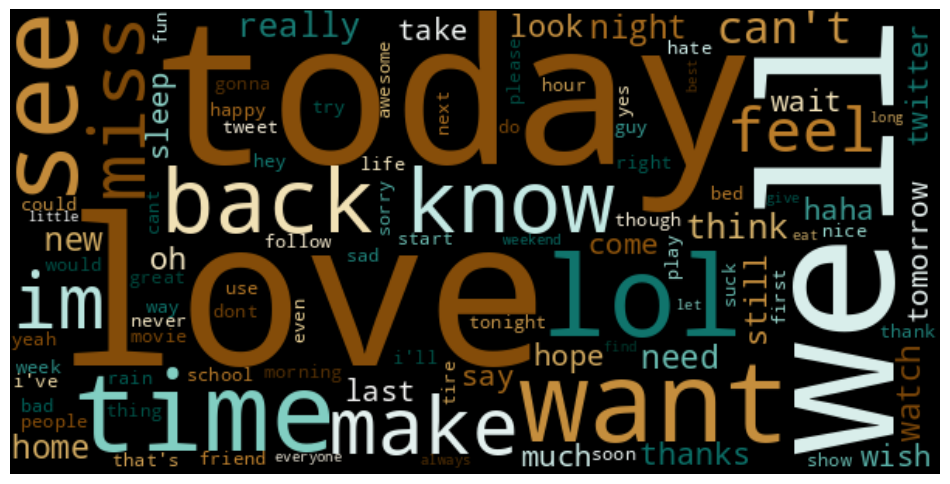

In [49]:
words_to_exclude = [
    "...", ".."
]
tags_to_remove=["NNP", "VBG", "VBN", "CD"]

corpus = natural_language_processing(
    data_words, "text", stem_or_lemma="lemma", debug=False, word_cloud=True,
    tags_to_remove=tags_to_remove, words_to_exclude=words_to_exclude)

In [50]:
data_words.head()

,filtexcl_words,filtpos_text,preproc_text,target,text
0,"[home, study, math, wooot, im, go, fail, shit]","[home, study, math, wooot, im, go, fail, shit]","[home, study, math, wooot, im, go, fail, shit]",0,home studying for maths wooot ! im so going to...
1,"[pickin, waitin, hurry, odeee, miss, dem, tabl...","[pickin, waitin, hurry, ..., odeee, miss, dem,...","[pickin, waitin, 2, hurry, ..., odeee, miss, d...",0,Pickin up waitin on 2 hurry up...I odeeee miss...
2,"[rather, average]","[rather, average]","[rather, average, 32370]",0,I rather average 32370
3,"[i'm, try, reach, dream, seem, impossible, adv...","[i'm, try, reach, dream, seem, impossible, adv...","[i'm, try, reach, dream, seem, impossible, adv...",0,"I'm trying to reach my dreams, but it seems im..."
4,"[song's, middle, change, want, born, arghhh]","[song's, middle, change, want, born, ..., arghhh]","[song's, middle, change, want, born, ..., arghhh]",0,this song's middle change just doesn't want to...


In [51]:
# drop des colonnes inutiles
data_words.drop(columns=["filtpos_text", "preproc_text", "text"], inplace=True)

In [52]:
def join_back(text):
    return ' '.join(text)

data_words['sentence'] = data_words['filtexcl_words'].apply(join_back)
data_words.rename(columns={"filtexcl_words": "list_words"}, inplace=True)

In [53]:
data_words.head()

,list_words,target,sentence
0,"[home, study, math, wooot, im, go, fail, shit]",0,home study math wooot im go fail shit
1,"[pickin, waitin, hurry, odeee, miss, dem, tabl...",0,pickin waitin hurry odeee miss dem table talk ...
2,"[rather, average]",0,rather average
3,"[i'm, try, reach, dream, seem, impossible, adv...",0,i'm try reach dream seem impossible advice
4,"[song's, middle, change, want, born, arghhh]",0,song's middle change want born arghhh


# ML

### Manage Seed

In [54]:
from numpy.random import seed
seed(42)
import tensorflow
tensorflow.random.set_seed(42)

In [55]:
# seed_value= 42

# # 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
# import os
# os.environ['PYTHONHASHSEED']=str(seed_value)

# # 2. Set the `python` built-in pseudo-random generator at a fixed value
# import random
# random.seed(seed_value)

# # 3. Set the `numpy` pseudo-random generator at a fixed value
# import numpy as np
# np.random.seed(seed_value)

# # 4. Set the `tensorflow` pseudo-random generator at a fixed value
# import tensorflow as tf
# tf.random.set_seed(seed_value)
# # for later versions: 
# # tf.compat.v1.set_random_seed(seed_value)

# # 5. Configure a new global `tensorflow` session
# from keras import backend as K
# session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=15, inter_op_parallelism_threads=15)
# sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
# tf.compat.v1.keras.backend.set_session(sess)

### Splitting data

In [56]:
from sklearn import model_selection

In [57]:
# 3 parties : train 60%, validation 20% and test 20%
X, y = np.array(data_words['sentence']), np.array(data_words['target'])

X_train, X_temp, y_train, y_temp = model_selection.train_test_split(
    X,
    y,
    test_size=0.4,
    stratify=y,
    random_state=42,
)

X_val, X_test, y_val, y_test = model_selection.train_test_split(
    X_temp,
    y_temp,
    test_size=0.5,
    stratify=y_temp,
    random_state=42,
)

In [58]:
X_opti = np.concatenate((X_train, X_val))

In [59]:
y_opti = np.concatenate((y_train, y_val))

### Word Embedding

In [60]:
# corpus = list of documents
corpus = data_words["list_words"].tolist()

In [61]:
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras import layers, losses, optimizers
from tensorflow import keras
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [62]:
MAX_SENTENCE_LENGTH = 800

In [63]:
tokenizer = tokenize_corpus(corpus)
    
X_train = sequence.pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=MAX_SENTENCE_LENGTH)
X_val = sequence.pad_sequences(tokenizer.texts_to_sequences(X_val), maxlen=MAX_SENTENCE_LENGTH)
X_opti = sequence.pad_sequences(tokenizer.texts_to_sequences(X_opti), maxlen=MAX_SENTENCE_LENGTH)
X_test  = sequence.pad_sequences(tokenizer.texts_to_sequences(X_test) , maxlen=MAX_SENTENCE_LENGTH)

# BERT

In [64]:
truc = bidule

NameError: name 'bidule' is not defined

In [65]:
from transformers import *
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig

2023/08/12 10:03:58 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of transformers. If you encounter errors during autologging, try upgrading / downgrading transformers to a supported version, or try upgrading MLflow.
2023/08/12 10:04:00 INFO mlflow.tracking.fluent: Autologging successfully enabled for transformers.


In [ ]:
from transformers import file_utils
print(file_utils.default_cache_path)

In [66]:
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case = True)
bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2, output_attentions = False, output_hidden_states = False)

loading file vocab.txt from cache at /home/slerendu/.cache/huggingface/hub/models--bert-base-uncased/snapshots/1dbc166cf8765166998eff31ade2eb64c8a40076/vocab.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /home/slerendu/.cache/huggingface/hub/models--bert-base-uncased/snapshots/1dbc166cf8765166998eff31ade2eb64c8a40076/tokenizer_config.json
loading configuration file config.json from cache at /home/slerendu/.cache/huggingface/hub/models--bert-base-uncased/snapshots/1dbc166cf8765166998eff31ade2eb64c8a40076/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_

In [68]:
input_ids=[]
attention_masks=[]

for sent in data_words["sentence"]:
    bert_inp = bert_tokenizer.encode_plus(
        sent, add_special_tokens=True, max_length=64, pad_to_max_length=True,
        return_attention_mask=True)
    input_ids.append(bert_inp['input_ids'])
    attention_masks.append(bert_inp['attention_mask'])

input_ids=np.asarray(input_ids)
attention_masks=np.array(attention_masks)
labels=np.array(data_words['target'])

# input_ids = torch.cat(input_ids,dim=0)
# attention_mask = torch.cat(attention_mask,dim=0)
# labels = torch.tensor(labels)

In [69]:
len(input_ids), len(attention_masks), len(labels)

(20000, 20000, 20000)

In [71]:
# bert_model.summary()

In [72]:
from sklearn import model_selection
import tensorflow as tf

In [73]:
# loss = losses.SparseCategoricalCrossentropy(from_logits=True)
# optimizer = optimizers.Adam(learning_rate=2e-5, epsilon=1e-08)
# learning_rate=2e-5 recommended by the Bert team

bert_model.compile(loss="sparse_categorical_crossentropy", optimizer="Adam", metrics=[tf.keras.metrics.AUC()])


AttributeError: 'BertForSequenceClassification' object has no attribute 'compile'

In [ ]:
train_inp, val_inp, train_label, val_label, train_mask, val_mask = model_selection.train_test_split(input_ids, labels, attention_masks, test_size=0.2)

In [ ]:
train_inp.shape, train_label.shape, train_mask.shape

In [ ]:
history=bert_model.fit(
    [train_inp,train_mask],train_label,batch_size=32,epochs=4,
    validation_data=([val_inp,val_mask],val_label))

In [ ]:
def display_result_plot_accuracy(history):
    spec,  val_spec  = history.history['categorical_accuracy'], history.history['val_categorical_accuracy']
    loss, val_loss = history.history['loss'], history.history['val_loss']
    epochs = range(len(spec))

    plt.plot(epochs, spec, 'b', label='Training spec')
    plt.plot(epochs, val_spec, 'r', label='Validation spec')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

In [ ]:
display_result_plot_accuracy(history)

In [ ]:
# compute confusion matrix and specificity
y_pred = bert_model.predict(X_val)

In [ ]:
y_pred

In [ ]:
pred_labels = y_pred["logits"].argmax(axis=1)

In [ ]:
pred_labels

In [ ]:
pred_res = []
for tup in y_pred["logits"]:
    if tup[1]>=0.5:
        pred_res.append(1)
    else:
        pred_res.append(0)

In [ ]:
speci = display_confusion_matrix(actual_class=y_val, predict_class=pred_labels, display_labels=["Negative", "Positive"], specifity=True)